In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from collections import defaultdict
from scipy.linalg import svd
import seaborn as sns
import multiprocessing
from functools import partial
import yaml
from causal_optoconnectics.graphics import regplot, scatterplot, probplot
from causal_optoconnectics.tools import conditional_probability, joint_probability, roll_pad
from causal_optoconnectics.tools import compute_trials_multi, decompress_events
from causal_optoconnectics.core import Connectivity
%matplotlib inline

# Process results

In [ ]:
sudo apt-get update; sudo apt-get install make build-essential libssl-dev zlib1g-dev libbz2-dev libreadline-dev libsqlite3-dev wget curl llvm libncursesw5-dev xz-utils tk-dev libxml2-dev libxmlsec1-dev libffi-dev liblzma-dev

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_2/')

In [4]:
x_i, x_j = 11, 13
y_i, y_j = 12, 19
z_i, z_j = 7, 10

def process_metadata(W, stim_index, params):
    
    pairs = []
    for i in range(params['n_neurons']):
        for j in range(params['n_neurons']):
            if i==j:
                continue
            pair = f'{i}_{j}'
            pairs.append({
                'source': i,
                'target': j,
                'pair': pair,
                'weight': W[i, j, 0],
                'source_stim': W[stim_index, i, 0] > 0,
                'source_stim_strength': W[stim_index, i, 0],
                'target_stim': W[stim_index, j, 0] > 0,
            })
    return pd.DataFrame(pairs)

def process(pair, trials, W, stim_index, params, n_trials=None):
    i, j = [int(a) for a in pair.split('_')]
    
    pre, post = trials[i], trials[j]
    
    n_trials = len(pre) if n_trials is None else n_trials
    
    conn = Connectivity(pre[:n_trials], post[:n_trials], x_i, x_j, y_i, y_j, z_i, z_j)
    
    result ={
        'source': i,
        'target': j,
        'pair': pair,
        'beta_iv': conn.beta_iv, 
        'beta': conn.beta,
        'beta_iv_did': conn.beta_iv_did, 
        'beta_did': conn.beta_did, 
        'hit_rate': conn.hit_rate,
        'weight': W[i, j, 0],
        'source_stim': W[stim_index, i, 0] > 0,
        'source_stim_strength': W[stim_index, i, 0],
        'target_stim': W[stim_index, j, 0] > 0,
    }
    result.update(params)
    return result

In [5]:
def multi_process(trials, W, stim_index, params, pairs=None):
    import multiprocessing
    from functools import partial
    if pairs is None:
        pairs = [f'{i}_{j}' for i in range(params['n_neurons']) for j in range(params['n_neurons']) if i!=j]
        
    with multiprocessing.Pool() as p:
        results = p.map(partial(process, trials=trials, W=W, stim_index=stim_index params=params), pairs)
        
    return pd.DataFrame(results)

In [6]:
from scipy.linalg import norm
from scipy.optimize import minimize_scalar

def error(a, df, key):
    return df['weight'] - a * df[key]

def error_norm(a, df, key):
    return norm(error(a, df, key))

def min_error(df, key):
    return minimize_scalar(error_norm, args=(df, key)).fun

In [7]:
paths = list(data_path.iterdir())
data_df = pd.DataFrame({'path': paths})
for i, fname in enumerate(paths):
    a,b,c = fname.stem.split('_')
    data_df.loc[i, 'n_neurons'], data_df.loc[i, 'stim_strength'], data_df.loc[i, 'sigma'] = a.replace('n', ''), b.replace('ss', ''), c.replace('s', '')
data_df = data_df.astype({'stim_strength': float, 'sigma': float, 'n_neurons': int})

In [9]:
data_df.sigma = data_df.apply(lambda x: 0.5 if x.path.stem.endswith('05') else x.sigma, 1)

In [10]:
data_df

,path,n_neurons,stim_strength,sigma
0,/home/users/bjornmik/datasets/sweep_2/n40_ss4_s4,40,4.0,4.0
1,/home/users/bjornmik/datasets/sweep_2/n10_ss2_s6,10,2.0,6.0
2,/home/users/bjornmik/datasets/sweep_2/n30_ss5_s5,30,5.0,5.0
3,/home/users/bjornmik/datasets/sweep_2/n10_ss2_s5,10,2.0,5.0
4,/home/users/bjornmik/datasets/sweep_2/n20_ss7_s4,20,7.0,4.0
...,...,...,...,...
315,/home/users/bjornmik/datasets/sweep_2/n30_ss7_s4,30,7.0,4.0
316,/home/users/bjornmik/datasets/sweep_2/n50_ss1_s2,50,1.0,2.0
317,/home/users/bjornmik/datasets/sweep_2/n40_ss5_s3,40,5.0,3.0
318,/home/users/bjornmik/datasets/sweep_2/n50_ss4_s3,50,4.0,3.0


In [11]:
def load(path):
    data = np.load(path / 'rank_0.npz', allow_pickle=True)   
    data = {k: data[k][()] for k in data.keys()}
    data['data'] = [np.load(fn, allow_pickle=True)['data'][()] for fn in path.glob('*.npz')]
    return data
#     data['all_params'] = [np.load(fn, allow_pickle=True)['params'][()] for fn in path.glob('*.npz')]
#     data['all_W_0'] = [np.load(fn, allow_pickle=True)['W_0'][()] for fn in path.glob('*.npz')]
#     data['all_W'] = [np.load(fn, allow_pickle=True)['W'][()] for fn in path.glob('*.npz')]
    
#     assert(all([a==b for a, b in zip(data['all_params'], data['all_params'][1:])]))
#     assert(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W_0'], data['all_W_0'][1:])]))
#     assert(all([np.array_equal(a,b,equal_nan=True) for a, b in zip(data['all_W'], data['all_W'][1:])]))
#     return data

In [16]:
values = pd.DataFrame()
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    data = load(row.path)
    X = data['data']
    W_0 = data['W_0']
    W = data['W']
    stim_index = len(W_0)
    params = data['params']
    
    with open(row.path / 'params.yaml', 'w') as file:
        yaml.dump(params, file)
    
    n_neurons = params['n_neurons']
    assert n_neurons == row.n_neurons
    trials = compute_trials_multi(X, len(W_0), stim_index)
    np.savez(row.path / 'trials', data=trials)
    
    s_W = svd(W_0, compute_uv=False)
    data_df.loc[i, 'W_condition'] = s_W.max() / s_W.min()
    data_df.loc[i, 'W_smin'] = s_W.min()
    data_df.loc[i, 'W_smax'] = s_W.max()

    x = decompress_events(X[0], len(W), params['n_time_step'])
    cov_x = np.cov(x[:len(W_0)])
    s_cov = svd(cov_x, compute_uv=False)
    data_df.loc[i, 'cov_condition'] = s_cov.max() / s_cov.min()
    data_df.loc[i, 'cov_smin'] = s_cov.min()
    data_df.loc[i, 'cov_smax'] = s_cov.max()

    results_meta = process_metadata(W=W, stim_index=stim_index, params=params)
    sample_meta = results_meta.query('source_stim and not target_stim and weight >= 0')
#     sample = pd.DataFrame([process(pair=pair, W=W, stim_index=stim_index, trials=trials, params=params) for pair in sample_meta.pair.values])
    sample = multi_process(trials=trials, W=W, stim_index=stim_index, params=params, pairs=sample_meta.pair.values)
    sample.to_csv(row.path / 'sample.csv')
    values = pd.concat((values, sample))
    data_df.loc[i, 'error_beta_did'] = min_error(sample, 'beta_did')
    data_df.loc[i, 'error_beta_iv_did'] = min_error(sample, 'beta_iv_did')
    data_df.loc[i, 'error_beta'] = min_error(sample, 'beta')
    data_df.loc[i, 'error_beta_iv'] = min_error(sample, 'beta_iv')

  0%|          | 0/320 [00:00<?, ?it/s]

In [17]:
data_df.loc[:,'error_diff'] = data_df.error_beta - data_df.error_beta_iv

In [18]:
data_df.to_csv(data_path / 'summary.csv')

In [19]:
values.to_csv(data_path / 'values.csv')

In [20]:
sub_df = data_df.query('n_neurons == 50')

/tmp/ipykernel_768930/796403364.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())


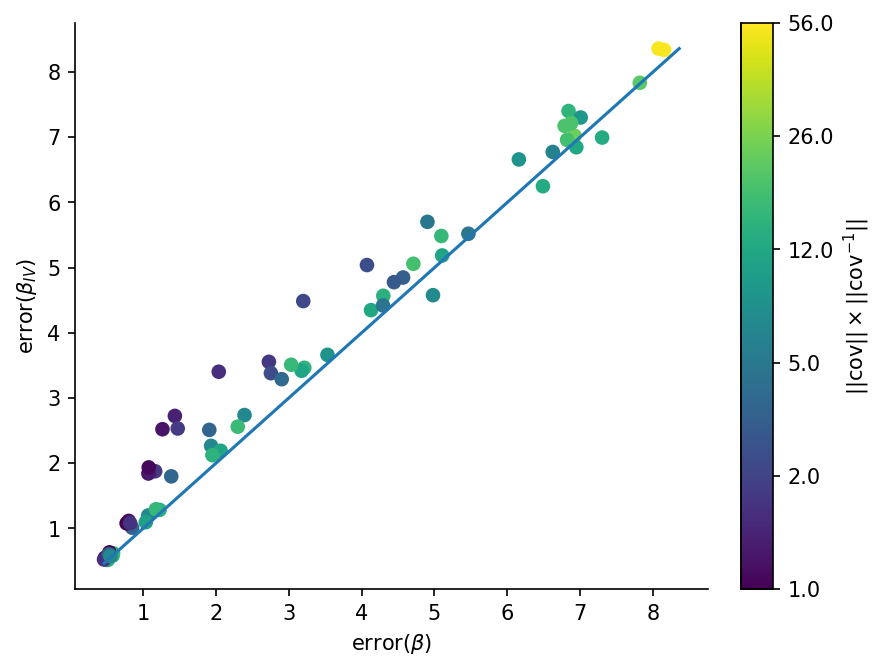

In [21]:
import matplotlib
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5), dpi=150)
mnorm = matplotlib.colors.LogNorm()
xmin, xmax = min(sub_df.error_beta.min(), sub_df.error_beta_iv.min()), max(sub_df.error_beta.max(), sub_df.error_beta_iv.max())
sc = ax.scatter(sub_df.error_beta, sub_df.error_beta_iv, c=mnorm(sub_df.cov_condition))
ax.plot([xmin, xmax], [xmin, xmax])
ax.set_xlabel(r'$\mathrm{error}(\beta)$')
ax.set_ylabel(r'$\mathrm{error}(\beta_{IV})$')
cbar = plt.colorbar(sc, cax=cax)
cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
sns.despine()

In [22]:
data_df

,path,n_neurons,stim_strength,sigma,W_condition,W_smin,W_smax,cov_condition,cov_smin,cov_smax,error_beta,error_beta_iv,error_diff
0,/home/users/bjornmik/datasets/sweep_2/n40_ss4_s4,40,4.0,4.0,2.253010e+18,8.930944e-18,20.121510,4.455979,0.005292,0.023580,3.343913,3.188489,0.155424
1,/home/users/bjornmik/datasets/sweep_2/n10_ss2_s6,10,2.0,6.0,1.018954e+18,1.622841e-17,16.536003,3.739396,0.005161,0.019300,1.952472,2.807408,-0.854936
2,/home/users/bjornmik/datasets/sweep_2/n30_ss5_s5,30,5.0,5.0,9.779233e+17,2.258320e-17,22.084640,8.338777,0.005018,0.041841,4.257807,4.517005,-0.259198
3,/home/users/bjornmik/datasets/sweep_2/n10_ss2_s5,10,2.0,5.0,2.543190e+17,5.432045e-17,13.814723,3.199048,0.006069,0.019414,3.063940,2.554183,0.509757
4,/home/users/bjornmik/datasets/sweep_2/n20_ss7_s4,20,7.0,4.0,5.198479e+18,2.667558e-18,13.867243,13.689638,0.005542,0.075872,4.081411,3.791291,0.290120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,/home/users/bjornmik/datasets/sweep_2/n30_ss7_s4,30,7.0,4.0,4.943820e+18,3.575588e-18,17.677065,13.420456,0.005689,0.076351,4.026917,4.748724,-0.721807
316,/home/users/bjornmik/datasets/sweep_2/n50_ss1_s2,50,1.0,2.0,7.645339e+18,1.479987e-18,11.315002,1.230111,0.005522,0.006793,1.077932,1.935788,-0.857856
317,/home/users/bjornmik/datasets/sweep_2/n40_ss5_s3,40,5.0,3.0,2.793682e+18,5.523621e-18,15.431237,7.455405,0.005370,0.040036,2.523284,2.646752,-0.123468
318,/home/users/bjornmik/datasets/sweep_2/n50_ss4_s3,50,4.0,3.0,3.783916e+19,4.486229e-19,16.975514,4.021934,0.005622,0.022613,1.909349,2.511392,-0.602042


In [23]:
plt.rcParams.update({'figure.figsize': (5,5), 'figure.dpi': 150})

<AxesSubplot:xlabel='stim_strength', ylabel='sigma'>

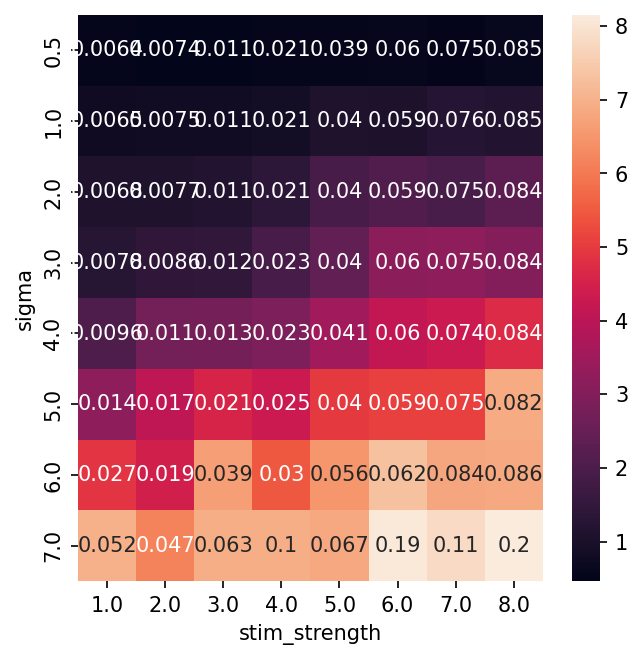

In [24]:
sns.heatmap(sub_df.pivot('sigma', 'stim_strength', 'error_beta'), annot=sub_df.pivot('sigma', 'stim_strength', 'cov_smax'))

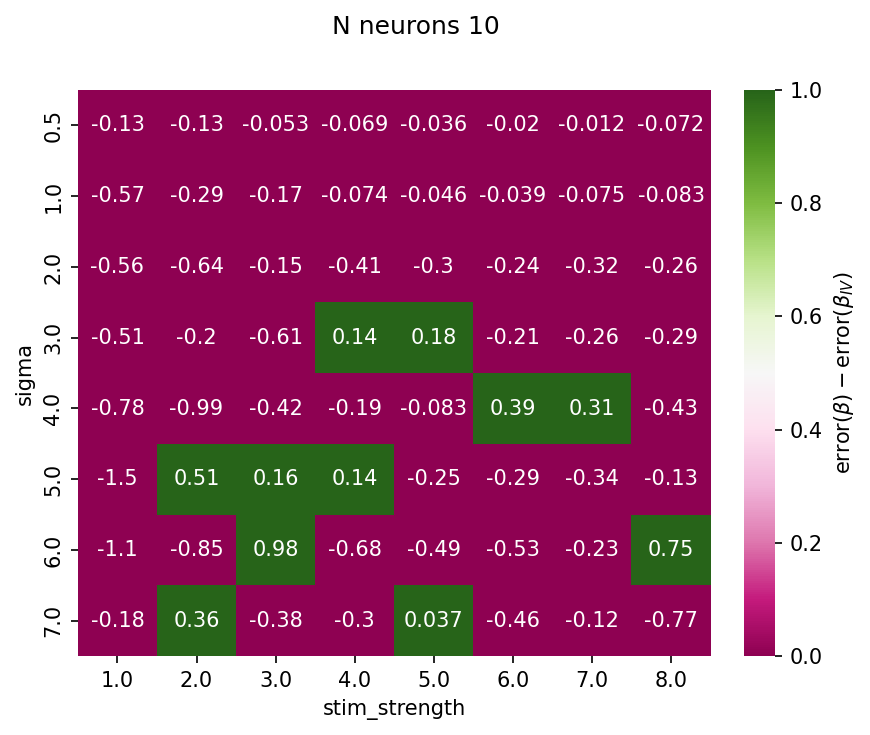

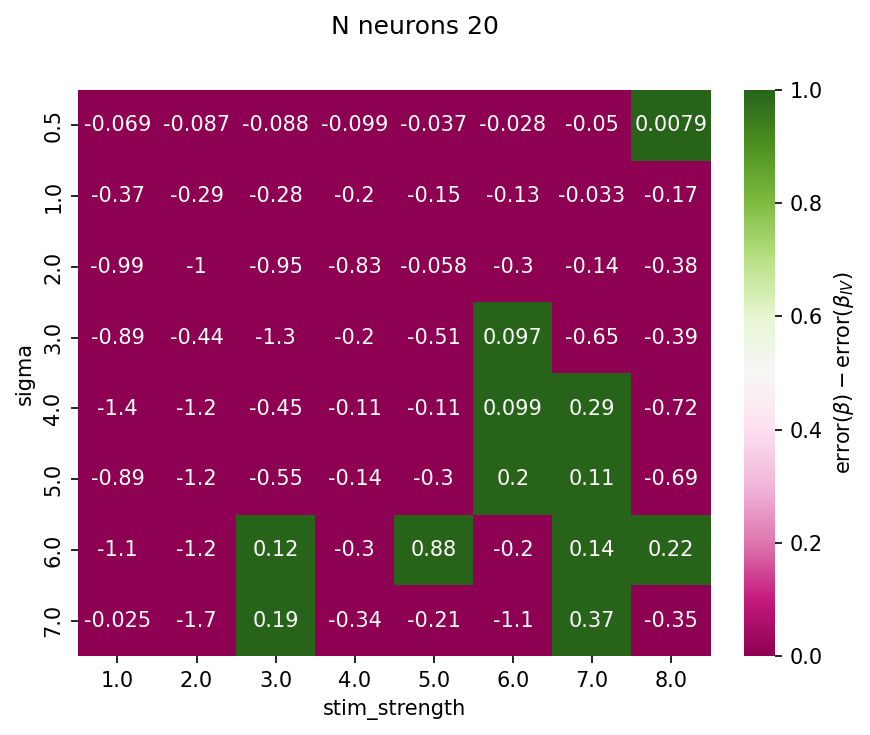

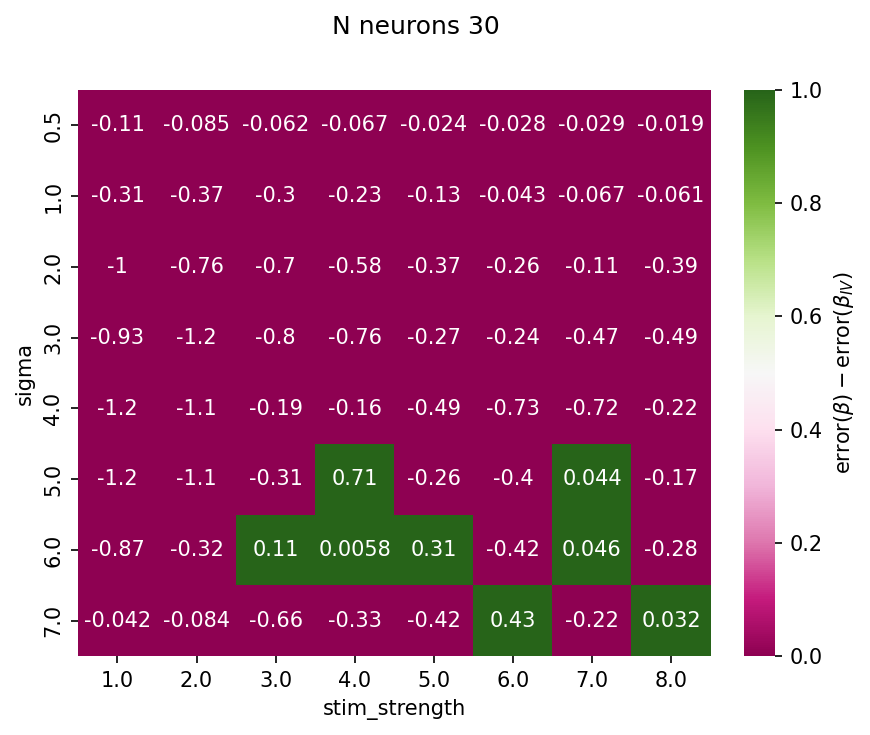

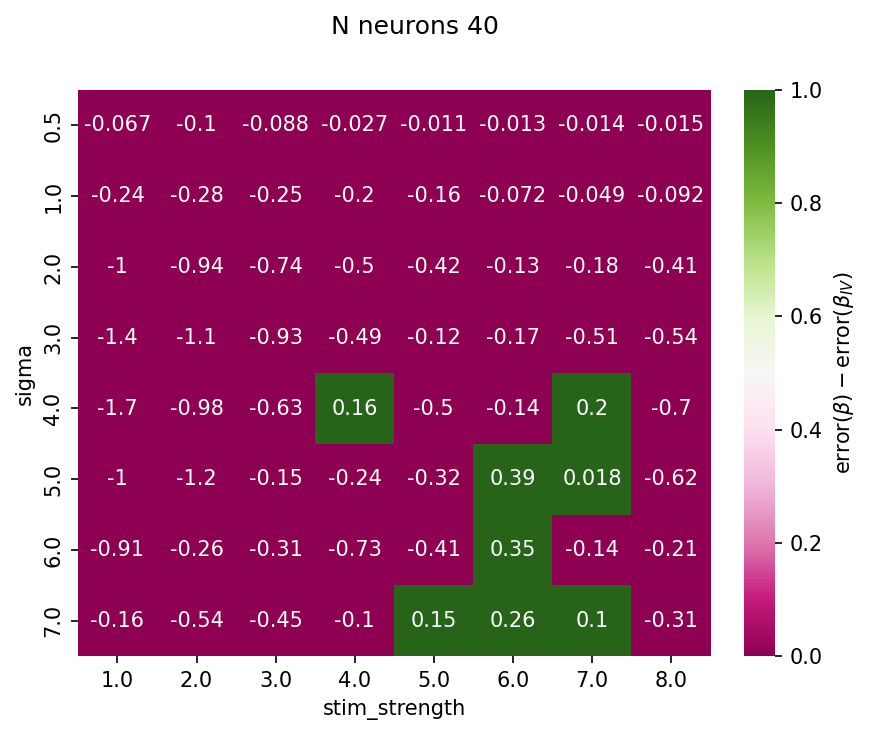

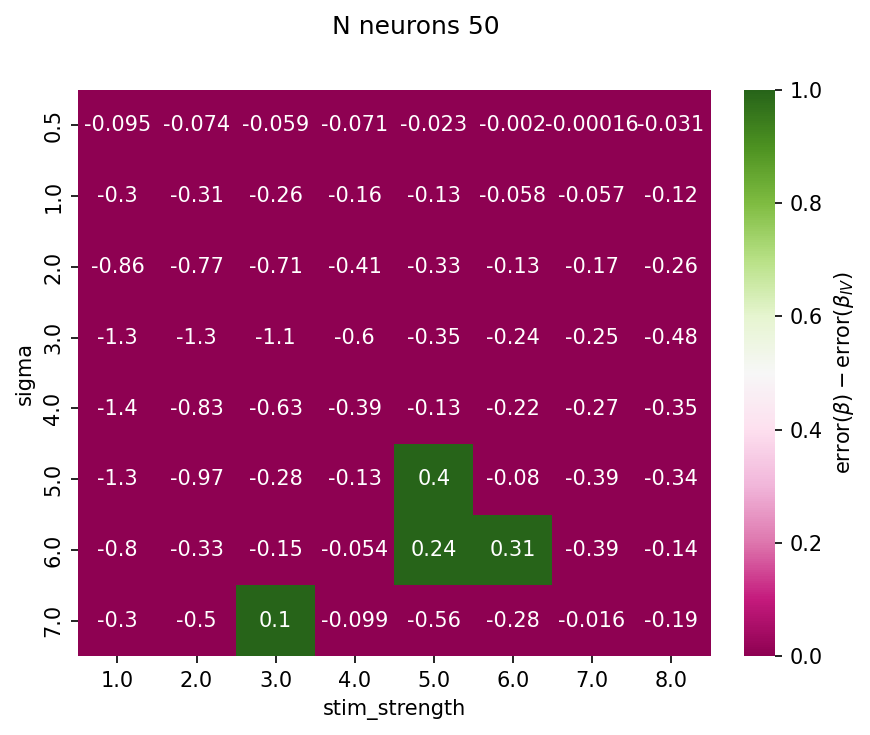

In [27]:
for n_neurons, df in data_df.groupby('n_neurons'):
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(6,5))
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_diff') > 0, 
        annot=df.pivot('sigma', 'stim_strength', 'error_diff'), 
        cmap='PiYG', vmin=0, vmax=1, cbar_ax=cax, ax=ax, cbar_kws={'label': r'$\mathrm{error}(\beta) - \mathrm{error}(\beta_{IV})$'})
    fig.suptitle(f'N neurons {n_neurons}')
# ax.set_ylabel('Stimulus strength')
# ax.set_xlabel(r'$\sigma$')